In [1]:
import numpy as np
import pyfftw

from math import pi
import math

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
import scipy.signal
from numpy import linalg as LA
#from matplotlib.mlab import griddata
params = {'legend.fontsize': 15,
          'legend.loc':'best',
          'figure.figsize': (14,5),
          'lines.markerfacecolor':'none',
         'axes.labelsize': 17,
         'axes.titlesize': 17,
         'xtick.labelsize':15,
         'ytick.labelsize':15,
         'grid.alpha':0.6}
pylab.rcParams.update(params)
#%matplotlib notebook
%matplotlib inline

from tqdm import tqdm
import sys

## Define directories

In [2]:
vtu_dir = '../vtu/'
meshfile_dir = '../../geo/'

## Import VTK files

In [3]:
import vtkreader as reader

start = 100.00 #50
end = 150.00   #199.98
dt = 0.1  #0.02

time = np.arange(start, end, dt)
filename = []
for i in range(len(time)):
    filename.append(vtu_dir+"{:.2f}".format(time[i])+'.vtu')

x,y = reader.load_coordinate(filename[0])
#NcellData,Ncell,cellData = reader.load_cell(filename[0])



p = np.zeros([len(time),len(x)])    # only p is interested here
u = np.zeros([len(time),len(x)])    # only p is interested here
v = np.zeros([len(time),len(x)])    # only p is interested here
rho = np.zeros([len(time),len(x)])    # only p is interested here



for i in tqdm(range(len(time))):
    p[i],u[i],v[i],rho[i] = reader.load_vtkFile(filename[i])
    if time[i] == end:
        print('loading data: done!')

print(p.shape)

100%|██████████| 500/500 [00:08<00:00, 59.80it/s]

(500, 448390)


In [4]:
# Read the source file.
import vtk
import vtk.util.numpy_support as ns
reader = vtk.vtkXMLUnstructuredGridReader()   # read the fucking file
reader.SetFileName(filename[0])
reader.Update()                               # Needed because of GetScalarRange

NcellData = reader.GetOutput().GetCells().GetData().GetNumberOfTuples()
Ncell = reader.GetOutput().GetNumberOfCells()
cellData = ns.vtk_to_numpy(reader.GetOutput().GetCells().GetData()) 

In [5]:
def quad_area(x,y):
    index1 = [0,1,2]
    index2 = [1,2,3]
    index3 = [2,3,0]
    index4 = [3,0,1]
    a1 = tri_area(x[index1],y[index1])
    a2 = tri_area(x[index2],y[index2])
    a3 = tri_area(x[index3],y[index3])
    a4 = tri_area(x[index4],y[index4])
    
    
    return 1/2*(a1+a2+a3+a4)
def tri_area(x,y):
    # area of triangle by calculate Jacobian determint
    area = x[1]*y[2]+x[2]*y[0]+x[0]*y[1]-x[1]*y[0]-x[2]*y[1]-x[0]*y[2]
    return 1/2*abs(area)

In [6]:
cellType = np.zeros(Ncell)
cell_quad = []
cell_tri = []
area = np.zeros(x.shape[0])

k = 0
for i in tqdm(range(Ncell)):
    cellType[i] = reader.GetOutput().GetCell(i).GetCellType()
    if cellType[i] == 9:
        cell_quad.append(i)
        
        index = cellData[k+1:k+5]
        area[index] += 1/4*quad_area(x[index],y[index])
        k += 5
        
    elif cellType[i] == 5:
        cell_tri.append(i)
        index = cellData[k+1:k+4]
        area[index] += 1/3*tri_area(x[index],y[index])
        k += 4
        
    else:
        raise ValueError('Nah, something wrong,cell type is not supported')
        break

100%|██████████| 454464/454464 [00:04<00:00, 106473.73it/s]


In [7]:
print(len(cell_tri)*4+len(cell_quad)*5)
print(cell_quad[0])
print(NcellData)
print(cellData[0:100])

1853584
245088
1853584
[ 3  0  1  5  3  6  1  5  3  1  2  6  3  7  2  6  3  2  3  7  3  8  3  7
  3  3  4  8  3  5  6  9  3 10  6  9  3  6  7 10  3 11  7 10  3  7  8 11
  3  9 10 12  3 13 10 12  3 10 11 13  3 12 13 14  3 15 16 20  3 21 16 20
  3 16 17 21  3 22 17 21  3 17 18 22  3 23 18 22  3 18 19 23  3 20 21 24
  3 25 21 24]


In [8]:
for i in range(area.shape[0]):  ##check if area is negative
    if area[i] <= 0:
        print(i)
        break

## Hanifi Norm

In [9]:
T = np.divide(p,rho)/287.058

In [10]:
import basis

dp,dpmean,dptuda = basis.fluc_pressure(p,time)
du,dumean,dutuda = basis.fluc_varibles(u,time,0.3*1.0)
dv,dvmean,dvtuda = basis.fluc_varibles(v,time,0.0)
drho,drhomean,drhotuda = basis.fluc_varibles(rho,time,1.0)
dT,dTmean,dTtuda = basis.fluc_varibles(T,time,1/1.4/1/287.058)

In [11]:
## assemble input matrix

# TKE
flucU = np.concatenate((dutuda,dvtuda),axis=1)

# Compressible energy norm
HN_E = np.concatenate((drhotuda,dutuda,dvtuda,dTtuda),axis=1)  ##input varibles

gamma = 1.4
rho_inf = 1.0
c_inf = 1.0
M = 0.3*c_inf
p_inf = c_inf*c_inf*rho_inf/gamma
T_inf = p_inf/rho_inf/287.058

rho_mean = np.sum(rho,axis=0)/rho.shape[0]   ##calculate local mean values
T_mean = np.sum(T,axis=0)/T.shape[0]

## assemble W before the integral
HN_mean = np.concatenate((T_mean/rho_mean/gamma/M/M,rho_mean,rho_mean,rho_mean/gamma/(1-gamma)/T_mean/M/M),axis=None)

In [12]:
HN_E.shape

(500, 1793560)

In [13]:
def TKE_norm(flucU,area):
    if flucU.shape[0] < flucU.shape[1]:
        Y = flucU.T
    elif var.shape[1] < flucU.shape[0]:
        Y = flucU
    else:
        ValueError('No mate, input data shape is not alright, it is not gonna work')
        return 0
    
    
    # build weight matrix (vector)
    W = np.zeros(area.shape[0]*int(Y.shape[0]/area.shape[0]))
    W[0:area.shape[0]] += area
    W[area.shape[0]:] += area    
    
    # TKE calculation
    aa = np.zeros([Y.T.shape[0],Y.T.shape[1]])
    for i in range(Y.T.shape[0]):
        aa[i] = Y.T[i]*W
    TKE = np.diag(np.dot(aa,Y))
    
    return TKE
    

In [14]:
def Hanifi_norm(total,area,meanvalues):
    if total.shape[0] < total.shape[1]:
        Y = total.T
    elif var.shape[1] < total.shape[0]:
        Y = total
    else:
        ValueError('No mate, input data shape is not alright, it is not gonna work')
        return 0
    
    # build weight matrix (vector)
    W = np.zeros(area.shape[0]*int(Y.shape[0]/area.shape[0]))
    for i in range(int(Y.shape[0]/area.shape[0])):
        W[i*area.shape[0]:(i+1)*area.shape[0]] = area*meanvalues[i*area.shape[0]:(i+1)*area.shape[0]]
    
    # hanifi norm
    aa = np.zeros([Y.T.shape[0],Y.T.shape[1]])
    for i in range(Y.T.shape[0]):
        aa[i] = Y.T[i]*W
    #HN = np.diag(np.dot(aa,Y))
    HN = np.dot(aa,Y)
    
    return HN

In [15]:
TKE = TKE_norm(flucU,area)
TKE.shape

(500,)

In [16]:
HN = Hanifi_norm(HN_E,area,HN_mean)
HN.shape

(500, 500)

Text(0, 0.5, 'TKE')

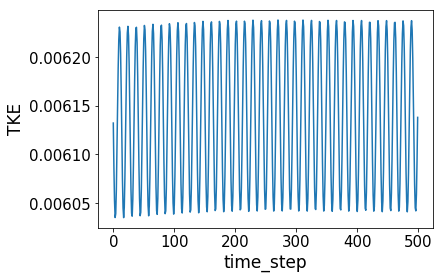

In [17]:
plt.plot(np.arange(time.shape[0]),TKE,'-')
#plt.yscale('log')
plt.xlabel('time_step')
plt.ylabel('TKE')

Text(0, 0.5, 'HN')

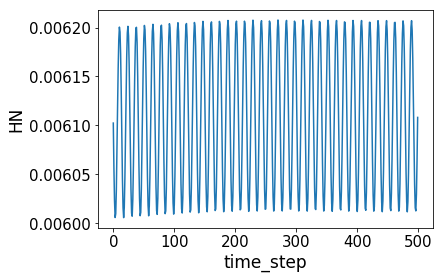

In [18]:
plt.plot(np.arange(time.shape[0]),np.diag(HN),'-')
#plt.yscale('log')
plt.xlabel('time_step')
plt.ylabel('HN')
#plt.xlim([0,100])

In [19]:
"""/ Linear cells
  VTK_EMPTY_CELL: 0,
  VTK_VERTEX: 1,
  VTK_POLY_VERTEX: 2,
  VTK_LINE: 3,
  VTK_POLY_LINE: 4,
  VTK_TRIANGLE: 5,
  VTK_TRIANGLE_STRIP: 6,
  VTK_POLYGON: 7,
  VTK_PIXEL: 8,
  VTK_QUAD: 9,
  VTK_TETRA: 10,
  VTK_VOXEL: 11,
  VTK_HEXAHEDRON: 12,
  VTK_WEDGE: 13,
  VTK_PYRAMID: 14,
  VTK_PENTAGONAL_PRISM: 15,
  VTK_HEXAGONAL_PRISM: 16,

  // Quadratic, isoparametric cells
  VTK_QUADRATIC_EDGE: 21,
  VTK_QUADRATIC_TRIANGLE: 22,
  VTK_QUADRATIC_QUAD: 23,
  VTK_QUADRATIC_POLYGON: 36,
  VTK_QUADRATIC_TETRA: 24,
  VTK_QUADRATIC_HEXAHEDRON: 25,
  VTK_QUADRATIC_WEDGE: 26,
  VTK_QUADRATIC_PYRAMID: 27,
  VTK_BIQUADRATIC_QUAD: 28,
  VTK_TRIQUADRATIC_HEXAHEDRON: 29,
  VTK_QUADRATIC_LINEAR_QUAD: 30,
  VTK_QUADRATIC_LINEAR_WEDGE: 31,
  VTK_BIQUADRATIC_QUADRATIC_WEDGE: 32,
  VTK_BIQUADRATIC_QUADRATIC_HEXAHEDRON: 33,
  VTK_BIQUADRATIC_TRIANGLE: 34,"""

'/ Linear cells\n  VTK_EMPTY_CELL: 0,\n  VTK_VERTEX: 1,\n  VTK_POLY_VERTEX: 2,\n  VTK_LINE: 3,\n  VTK_POLY_LINE: 4,\n  VTK_TRIANGLE: 5,\n  VTK_TRIANGLE_STRIP: 6,\n  VTK_POLYGON: 7,\n  VTK_PIXEL: 8,\n  VTK_QUAD: 9,\n  VTK_TETRA: 10,\n  VTK_VOXEL: 11,\n  VTK_HEXAHEDRON: 12,\n  VTK_WEDGE: 13,\n  VTK_PYRAMID: 14,\n  VTK_PENTAGONAL_PRISM: 15,\n  VTK_HEXAGONAL_PRISM: 16,\n\n  // Quadratic, isoparametric cells\n  VTK_QUADRATIC_EDGE: 21,\n  VTK_QUADRATIC_TRIANGLE: 22,\n  VTK_QUADRATIC_QUAD: 23,\n  VTK_QUADRATIC_POLYGON: 36,\n  VTK_QUADRATIC_TETRA: 24,\n  VTK_QUADRATIC_HEXAHEDRON: 25,\n  VTK_QUADRATIC_WEDGE: 26,\n  VTK_QUADRATIC_PYRAMID: 27,\n  VTK_BIQUADRATIC_QUAD: 28,\n  VTK_TRIQUADRATIC_HEXAHEDRON: 29,\n  VTK_QUADRATIC_LINEAR_QUAD: 30,\n  VTK_QUADRATIC_LINEAR_WEDGE: 31,\n  VTK_BIQUADRATIC_QUADRATIC_WEDGE: 32,\n  VTK_BIQUADRATIC_QUADRATIC_HEXAHEDRON: 33,\n  VTK_BIQUADRATIC_TRIANGLE: 34,'